## I tried to make things give better results by trying 4 different algoruthms to get the best possible prediction

##  Import necessary  libraies
#### We import needed packages for data preprocessing and models fitting

In [1]:
!pip install pandasql

In [0]:
import pandasql as ps


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans


In [0]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
%matplotlib inline

In [0]:
import math
from scipy import stats

In [0]:
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import skew
from collections import OrderedDict

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link='https://drive.google.com/open?id=1m2GdiYeJFulUjbOTiciYY3h2Osw5F1mU'


## Importing data : 
#### We import data , read it into pandas dataset

In [10]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1m2GdiYeJFulUjbOTiciYY3h2Osw5F1mU


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test_set.csv')  

In [0]:
test=pd.read_csv('test_set.csv')

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link='https://drive.google.com/open?id=1k2lw5exkiOGFBc0JXmApd-MnutcK9KZG'


In [14]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1k2lw5exkiOGFBc0JXmApd-MnutcK9KZG


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_set.csv')  

In [0]:
train=pd.read_csv('train_set.csv')

### then we do some exploration on data , its characterestics , and needed cleaning and processing

#### First we demonstrate how data is stored

In [17]:
train.head()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,9.767406e+10,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0
1,9.768889e+10,133876.0,67.0,3.0,12585.0,90.0,4.0,4371.0,17.383,189.38,28.0,4
2,9.811544e+10,133732.0,39.0,3.0,23491.0,83.0,3.0,1005.0,16.438,57.63,27.0,44
3,9.824279e+10,43772.0,59.0,8.0,3291.0,73.0,2.0,3084.0,7.000,72.16,2.0,4
4,9.833438e+10,50532.0,66.0,1.0,288.0,80.0,0.0,603.0,12.564,173.25,0.0,10


In [18]:
test.head()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent
0,14942256073,122750.0,58.0,2.0,11503.0,89.0,0.0,168.0,13.500,90.19,32.0
1,16036037903,28134.0,68.0,4.0,938.0,81.0,5.0,735.0,13.667,98.27,19.0
2,288585940112,30578.0,19.0,0.0,38982.0,NaN,0.0,0.0,20.462,48.77,0.0
3,129041645070,54398.0,47.0,0.0,1683.0,80.0,0.0,69.0,15.000,72.32,0.0
4,12460296563,63890.0,59.0,3.0,1299.0,80.0,3.0,1470.0,10.000,24.54,19.0


## We know that data manipulation process must be run the same way on train and test datasets , thus we  merge them during data manipulation steps , then we split them before trying prediction algorithms

In [0]:
train1=train.copy()

In [20]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396487 entries, 0 to 396486
Data columns (total 12 columns):
hotel_id              396487 non-null float64
city_id               395979 non-null float64
content_score         395979 non-null float64
n_images              395978 non-null float64
distance_to_center    395958 non-null float64
avg_rating            286089 non-null float64
stars                 395925 non-null float64
n_reviews             395958 non-null float64
avg_rank              396487 non-null float64
avg_price             396317 non-null float64
avg_saving_percent    396317 non-null float64
n_clicks              396487 non-null int64
dtypes: float64(11), int64(1)
memory usage: 36.3 MB


In [0]:
train1['train'] = 1

In [0]:
test['train'] = 0 

In [23]:
train1=pd.concat([train1 , test] , axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


#### we notice that the column , Hotel_id and City_id are stored as floats despite they are identifiers so they should be stored as strings, we are to modify that later

### Then we check missing values appearence in data

In [24]:
for i in train1.columns :
  print(i + " contains " , np.isnan(train1[i]).sum() , "NaN value")

avg_price contains  228 NaN value
avg_rank contains  0 NaN value
avg_rating contains  147028 NaN value
avg_saving_percent contains  228 NaN value
city_id contains  663 NaN value
content_score contains  663 NaN value
distance_to_center contains  692 NaN value
hotel_id contains  0 NaN value
n_clicks contains  132162 NaN value
n_images contains  665 NaN value
n_reviews contains  692 NaN value
stars contains  737 NaN value
train contains  0 NaN value


#### we notice a column like city_id includes 508 missing values , we will need later to wxclude them from the data , especiiallt that it is big enough to not be affected by these cases

####  then we will need to impute other columns , they are numeric , thus average is the most common option to impute them 

In [25]:
train1.loc[np.isnan(train1['city_id']) , ['avg_rank']].mean()

avg_rank    14.403128
dtype: float64

In [26]:
train1.loc[np.isnan(train1['city_id']) ==0 , ['avg_rank']].mean()

avg_rank    14.699844
dtype: float64

### about city_id , which is a categorical column , we will need to define a binary column for each option , but since data is big , and otions in city_id are a lot and a lot of them were only mentioned one time , we will need to specify columns for only cities that were mentioned more than a specific number

In [27]:
train1['city_id'].value_counts().head(10)

50168.0    3282
44470.0    2213
34798.0    2089
30576.0    1740
26874.0    1472
46884.0    1308
31786.0    1306
63440.0    1158
53604.0    1144
7696.0     1111
Name: city_id, dtype: int64

#### thus we specify a new column includes cities that were mentioned only more than 1000 times

In [0]:
f=list(train1['city_id'].value_counts()[(train1['city_id'].value_counts() > 1000)].index)


In [0]:
train1['city_id1'] = 0 

In [0]:
train1['city_id1'] = [x if x in f  else 0  for x in train1['city_id']]

In [32]:
train1['city_id1'].value_counts().head()

0.0        506665
50168.0      3282
44470.0      2213
34798.0      2089
30576.0      1740
Name: city_id1, dtype: int64

In [0]:
pd.options.display.float_format = "{:.2f}".format

#### then , let's describr the dataset : 

In [34]:
train1.describe()

,avg_price,avg_rank,avg_rating,avg_saving_percent,city_id,content_score,distance_to_center,hotel_id,n_clicks,n_images,n_reviews,stars,train,city_id1
count,528421.00,528649.00,381621.00,528421.00,527986.00,527986.00,527957.00,528649.00,396487.00,527984.00,527957.00,527912.00,528649.00,528649.00
mean,109.18,14.70,81.62,7.16,149207.27,50.98,16139.15,132668050617.89,13.78,283.76,910.56,1.16,0.75,2061.07
std,147.38,5.62,6.02,13.06,219290.12,11.57,269024.54,103420473052.88,123.57,18293.67,2453.64,1.62,0.43,11593.39
min,4.00,1.00,34.00,0.00,2.00,7.00,0.00,155796153.00,0.00,-1.00,0.00,0.00,0.00,0.00
25%,51.00,11.08,79.00,0.00,32010.00,45.00,544.00,40701082970.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,77.60,15.00,83.00,0.00,55122.00,53.00,1515.00,108602473300.00,0.00,1.00,186.00,0.00,1.00,0.00
75%,120.95,18.39,86.00,10.00,137456.00,59.00,4162.00,228375353198.00,2.00,2.00,774.00,3.00,1.00,0.00
max,8000.00,100.00,98.00,100.00,878736.00,81.00,18341550.00,323711383754.00,13742.00,2628317.00,283089.00,5.00,1.00,133876.00


#### we have another problem in the data , the column 'n_images' includes negative values , thus we need to inplace them.

#### Since it may indicate negative values , we replace it with the whole population mean

### but before that , we define a new dataset includes only cases with valid City_id

In [0]:
numeric_feats = ['content_score','n_images','distance_to_center' ,'stars','n_reviews','avg_rank','avg_price','avg_saving_percent']

In [0]:
train_new=train1.loc[np.isnan(train1['city_id'])==0 , :]



In [0]:
avg_n_images = train_new.loc[(train_new['n_images'] == -1)==0 ,: ]['n_images'].mean()

In [38]:
avg_n_images

286.2016851829212

In [39]:
train_new['n_images']=np.where(train_new['n_images'] ==-1 , avg_n_images , train_new['n_images'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### then we demonstrate the distribution of each numeric columns

distribution of  content_score


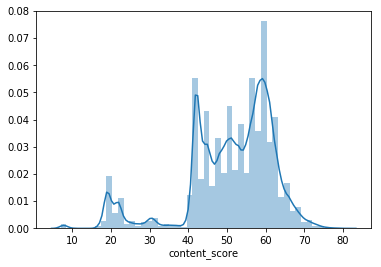

distribution of  n_images


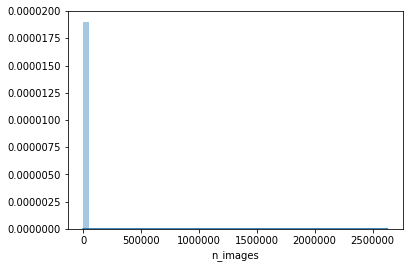

distribution of  distance_to_center


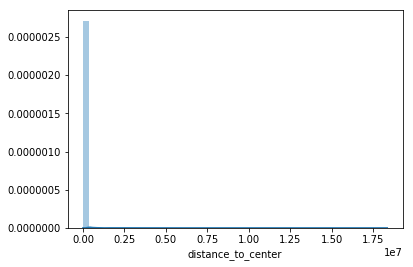

distribution of  stars


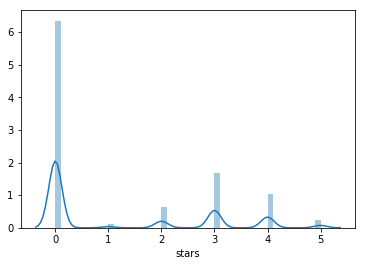

distribution of  n_reviews


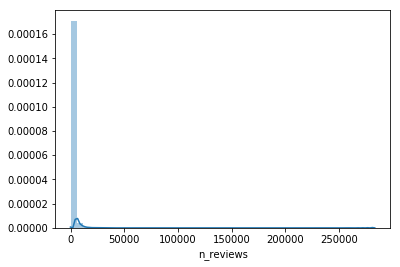

distribution of  avg_rank


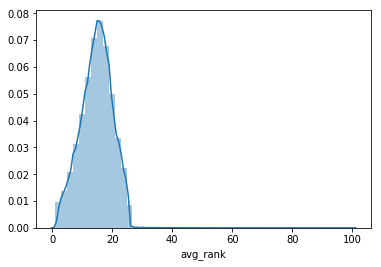

distribution of  avg_price


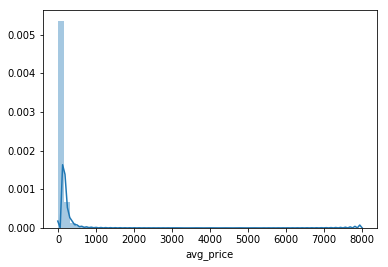

distribution of  avg_saving_percent


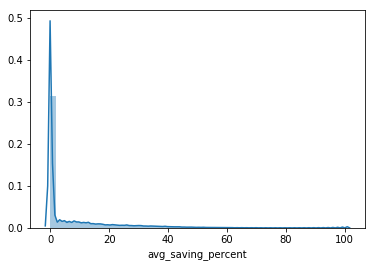

In [41]:
 for i in numeric_feats:
  print('distribution of ' , i)
  sns.distplot(train_new.loc[np.isnan(train_new[i]) == 0 ,:][i])
  plt.show()

### we notice that there are outliers in almost all columns , we replace them by bos plot whiskers as limits  

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


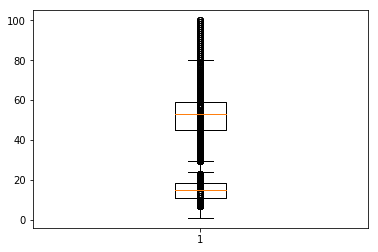

In [42]:
numeric_lower=[]
numeric_upper=[]
for i in numeric_feats:
    bp_i = plt.boxplot(train_new.loc[np.isnan(train[i]) == 0 ,:][i])
    lower_limit_i , upper_limit_i=[item.get_ydata()[1] for item in bp_i['whiskers']]
    numeric_lower.append(lower_limit_i)
    numeric_upper.append(upper_limit_i)
    

#### then we demonstrate upper and lower limits 

In [43]:
numeric_lower

[24.0, nan, nan, nan, nan, 1.0, nan, nan]

In [44]:
numeric_upper

[80.0, nan, nan, nan, nan, 29.353, nan, nan]

### then we replace outliers by these limits to make data more smooth

In [45]:
j=0
for i  in numeric_feats : 
    train_new[i]=np.where(train_new[i] < numeric_lower[j] , numeric_lower[j] , train_new[i])
    train_new[i]=np.where(train_new[i] > numeric_upper[j] , numeric_upper[j] , train_new[i])
    j+=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### then let's check data distributions :

distribution of  content_score


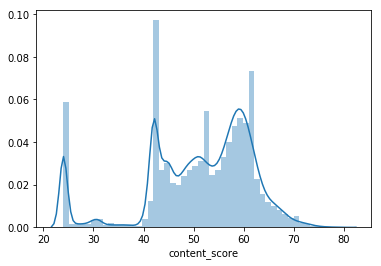

distribution of  n_images


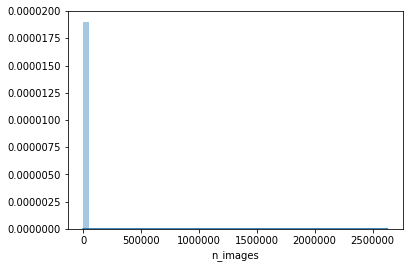

distribution of  distance_to_center


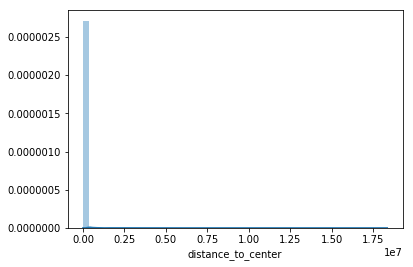

distribution of  stars


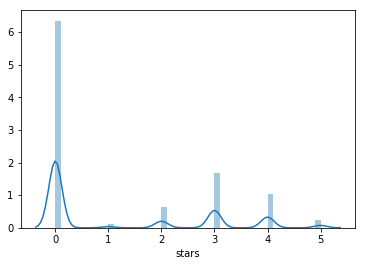

distribution of  n_reviews


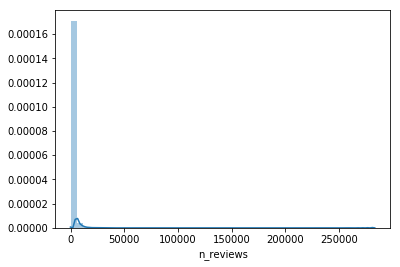

distribution of  avg_rank


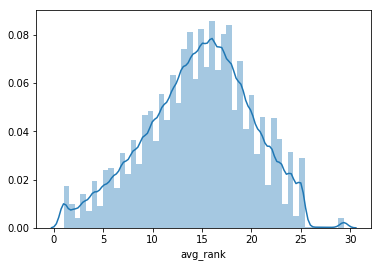

distribution of  avg_price


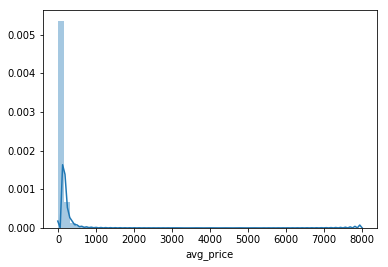

distribution of  avg_saving_percent


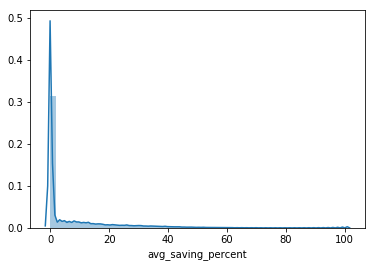

In [47]:
 for i in numeric_feats:
  print('distribution of ' , i)
  sns.distplot(train_new.loc[np.isnan(train_new[i]) == 0 ,:][i])
  plt.show()

#### we notice that distributions became much more acceptable especially clear in average price , average rank and  n_reviews

#### based on the data pure of non logical values and outliers , we can take averages safely to replace outliers

In [48]:
for i in train_new.columns :
   print(i + " contains " , np.isnan(train_new[i]).sum() , "NaN value")

avg_price contains  223 NaN value
avg_rank contains  0 NaN value
avg_rating contains  146365 NaN value
avg_saving_percent contains  223 NaN value
city_id contains  0 NaN value
content_score contains  0 NaN value
distance_to_center contains  29 NaN value
hotel_id contains  0 NaN value
n_clicks contains  132007 NaN value
n_images contains  2 NaN value
n_reviews contains  29 NaN value
stars contains  74 NaN value
train contains  0 NaN value
city_id1 contains  0 NaN value


In [0]:
avg_avg_rating=train_new['avg_rating'].mean()

In [0]:
avg_n_images=train_new['n_images'].mean()

In [0]:
avg_distance_to_center=train_new['distance_to_center'].mean()

In [0]:
avg_n_reviews=train_new['n_reviews'].mean()

In [0]:
avg_avg_price=train_new['avg_price'].mean()

In [0]:
avg_stars=train_new['stars'].mean() 

In [0]:
avg_avg_saving_percent=train_new['avg_saving_percent'].mean()

In [56]:
train_new['avg_rating']=np.where(np.isnan(train_new['avg_rating']), avg_avg_rating , train_new['avg_rating'] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
train_new['n_images']=np.where(np.isnan(train_new['n_images']), avg_n_images , train_new['n_images'] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
train_new['distance_to_center']=np.where(np.isnan(train_new['distance_to_center']), avg_distance_to_center , train_new['distance_to_center'] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
train_new['n_reviews']=np.where(np.isnan(train_new['n_reviews']), avg_n_reviews , train_new['n_reviews'] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
train_new['avg_price']=np.where(np.isnan(train_new['avg_price']), avg_avg_price , train_new['avg_price'] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
train_new['stars']=np.where(np.isnan(train_new['stars']), avg_stars , train_new['stars'] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
train_new['avg_saving_percent']=np.where(np.isnan(train_new['avg_saving_percent']), avg_avg_saving_percent , train_new['avg_saving_percent'] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
for i in train_new.columns :
   print(i + " contains " , np.isnan(train_new[i]).sum() , "NaN value")

avg_price contains  0 NaN value
avg_rank contains  0 NaN value
avg_rating contains  0 NaN value
avg_saving_percent contains  0 NaN value
city_id contains  0 NaN value
content_score contains  0 NaN value
distance_to_center contains  0 NaN value
hotel_id contains  0 NaN value
n_clicks contains  132007 NaN value
n_images contains  0 NaN value
n_reviews contains  0 NaN value
stars contains  0 NaN value
train contains  0 NaN value
city_id1 contains  0 NaN value


### then we modify type of columns , Hotel_id to be the index 

In [0]:
train_new=train_new.set_index('hotel_id')

In [65]:
train_new.head()

,avg_price,avg_rank,avg_rating,avg_saving_percent,city_id,content_score,distance_to_center,n_clicks,n_images,n_reviews,stars,train,city_id1
hotel_id,,,,,,,,,,,,,
97674063206.00,81.64,17.55,77.00,18.00,134520.00,70.00,1199.00,0.00,2.00,861.00,4.00,1,0.00
97688892034.00,189.38,17.38,90.00,28.00,133876.00,67.00,12585.00,4.00,3.00,4371.00,4.00,1,133876.00
98115438910.00,57.63,16.44,83.00,27.00,133732.00,39.00,23491.00,44.00,3.00,1005.00,3.00,1,0.00
98242792374.00,72.16,7.00,73.00,2.00,43772.00,59.00,3291.00,4.00,8.00,3084.00,2.00,1,0.00
98334382194.00,173.25,12.56,80.00,0.00,50532.00,66.00,288.00,10.00,1.00,603.00,0.00,1,0.00


In [0]:
numeric_feats = ['content_score','n_images','distance_to_center' ,'stars','n_reviews','avg_rank','avg_price','avg_saving_percent']

#### also make city_id string (despite we will have to exclude it later)

In [0]:
train_new['city_id']=train_new['city_id'].astype('str')

In [68]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 527986 entries, 97674063206.0 to 99788791152.0
Data columns (total 13 columns):
avg_price             527986 non-null float64
avg_rank              527986 non-null float64
avg_rating            527986 non-null float64
avg_saving_percent    527986 non-null float64
city_id               527986 non-null object
content_score         527986 non-null float64
distance_to_center    527986 non-null float64
n_clicks              395979 non-null float64
n_images              527986 non-null float64
n_reviews             527986 non-null float64
stars                 527986 non-null float64
train                 527986 non-null int64
city_id1              527986 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 56.4+ MB


In [69]:
train_new.head()

,avg_price,avg_rank,avg_rating,avg_saving_percent,city_id,content_score,distance_to_center,n_clicks,n_images,n_reviews,stars,train,city_id1
hotel_id,,,,,,,,,,,,,
97674063206.00,81.64,17.55,77.00,18.00,134520.0,70.00,1199.00,0.00,2.00,861.00,4.00,1,0.00
97688892034.00,189.38,17.38,90.00,28.00,133876.0,67.00,12585.00,4.00,3.00,4371.00,4.00,1,133876.00
98115438910.00,57.63,16.44,83.00,27.00,133732.0,39.00,23491.00,44.00,3.00,1005.00,3.00,1,0.00
98242792374.00,72.16,7.00,73.00,2.00,43772.0,59.00,3291.00,4.00,8.00,3084.00,2.00,1,0.00
98334382194.00,173.25,12.56,80.00,0.00,50532.0,66.00,288.00,10.00,1.00,603.00,0.00,1,0.00


### then define indicator variable for each city had frequency of 1000 or more in the data

In [0]:
train_final=pd.get_dummies(train_new , columns=['city_id1'])

## After steps of data manipulation , we again separate datasets , to train and test datasets before trying predictions algorithms to predict n_clicks

In [0]:
train_final=train_final.loc[train_final['train'] ==1 ,: ]

In [0]:
test_final = train_final.loc[train_final['train'] ==0 ,: ]

In [0]:
train_final1=train_final.copy()

#### then for better estimation we try log transformation to get rid of skewness in the predictors

In [0]:
train_final1[numeric_feats] = np.log1p(train_final1[numeric_feats])




distribution of  content_score


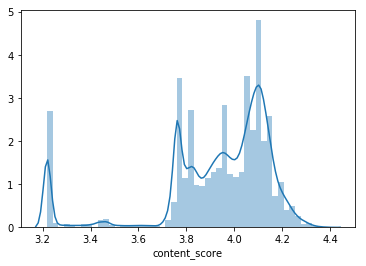

distribution of  n_images


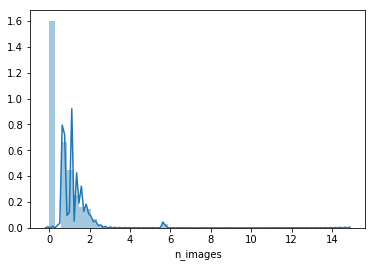

distribution of  distance_to_center


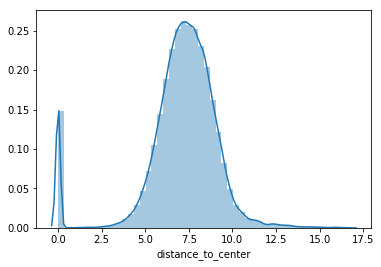

distribution of  stars


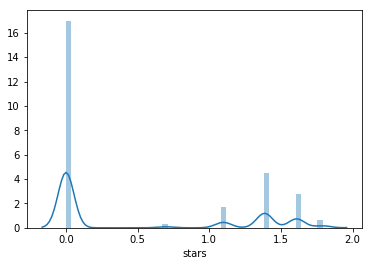

distribution of  n_reviews


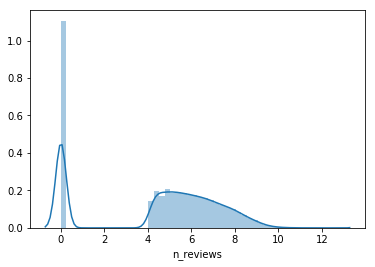

distribution of  avg_rank


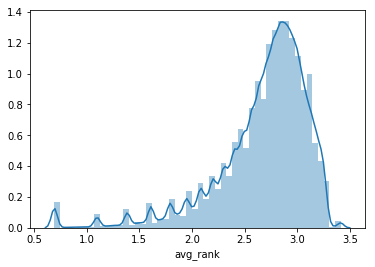

distribution of  avg_price


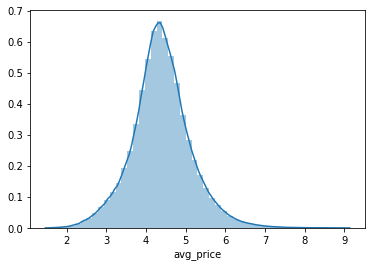

distribution of  avg_saving_percent


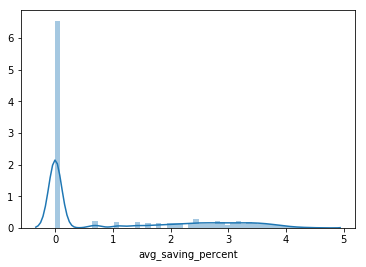

In [75]:
 for i in numeric_feats:
  print('distribution of ' , i)
  sns.distplot(train_final1.loc[np.isnan(train_final1[i]) == 0 ,:][i])
  plt.show()

In [76]:
train_final1.head()

,avg_price,avg_rank,avg_rating,avg_saving_percent,city_id,content_score,distance_to_center,n_clicks,n_images,n_reviews,stars,train,city_id1_0.0,city_id1_7696.0,city_id1_26874.0,city_id1_29468.0,city_id1_30576.0,city_id1_31786.0,city_id1_34798.0,city_id1_44470.0,city_id1_46884.0,city_id1_50168.0,city_id1_53222.0,city_id1_53604.0,city_id1_55122.0,city_id1_63440.0,city_id1_133754.0,city_id1_133876.0
hotel_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
97674063206.00,4.41,2.92,77.00,2.94,134520.0,4.26,7.09,0.00,1.10,6.76,1.61,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97688892034.00,5.25,2.91,90.00,3.37,133876.0,4.22,9.44,4.00,1.39,8.38,1.61,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
98115438910.00,4.07,2.86,83.00,3.33,133732.0,3.69,10.06,44.00,1.39,6.91,1.39,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98242792374.00,4.29,2.08,73.00,1.10,43772.0,4.09,8.10,4.00,2.20,8.03,1.10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98334382194.00,5.16,2.61,80.00,0.00,50532.0,4.20,5.67,10.00,0.69,6.40,0.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
train_final1.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 395979 entries, 97674063206.0 to 229370753854.0
Data columns (total 28 columns):
avg_price             395979 non-null float64
avg_rank              395979 non-null float64
avg_rating            395979 non-null float64
avg_saving_percent    395979 non-null float64
city_id               395979 non-null object
content_score         395979 non-null float64
distance_to_center    395979 non-null float64
n_clicks              395979 non-null float64
n_images              395979 non-null float64
n_reviews             395979 non-null float64
stars                 395979 non-null float64
train                 395979 non-null int64
city_id1_0.0          395979 non-null uint8
city_id1_7696.0       395979 non-null uint8
city_id1_26874.0      395979 non-null uint8
city_id1_29468.0      395979 non-null uint8
city_id1_30576.0      395979 non-null uint8
city_id1_31786.0      395979 non-null uint8
city_id1_34798.0      395979 non-null uint8
city_id1_4

In [0]:
train_final1=train_final1.drop(columns=['city_id1_0.0' , 'city_id'])

In [79]:
train_final1.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 395979 entries, 97674063206.0 to 229370753854.0
Data columns (total 26 columns):
avg_price             395979 non-null float64
avg_rank              395979 non-null float64
avg_rating            395979 non-null float64
avg_saving_percent    395979 non-null float64
content_score         395979 non-null float64
distance_to_center    395979 non-null float64
n_clicks              395979 non-null float64
n_images              395979 non-null float64
n_reviews             395979 non-null float64
stars                 395979 non-null float64
train                 395979 non-null int64
city_id1_7696.0       395979 non-null uint8
city_id1_26874.0      395979 non-null uint8
city_id1_29468.0      395979 non-null uint8
city_id1_30576.0      395979 non-null uint8
city_id1_31786.0      395979 non-null uint8
city_id1_34798.0      395979 non-null uint8
city_id1_44470.0      395979 non-null uint8
city_id1_46884.0      395979 non-null uint8
city_id1_50

In [80]:
train_final1.head()

,avg_price,avg_rank,avg_rating,avg_saving_percent,content_score,distance_to_center,n_clicks,n_images,n_reviews,stars,train,city_id1_7696.0,city_id1_26874.0,city_id1_29468.0,city_id1_30576.0,city_id1_31786.0,city_id1_34798.0,city_id1_44470.0,city_id1_46884.0,city_id1_50168.0,city_id1_53222.0,city_id1_53604.0,city_id1_55122.0,city_id1_63440.0,city_id1_133754.0,city_id1_133876.0
hotel_id,,,,,,,,,,,,,,,,,,,,,,,,,,
97674063206.00,4.41,2.92,77.00,2.94,4.26,7.09,0.00,1.10,6.76,1.61,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97688892034.00,5.25,2.91,90.00,3.37,4.22,9.44,4.00,1.39,8.38,1.61,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
98115438910.00,4.07,2.86,83.00,3.33,3.69,10.06,44.00,1.39,6.91,1.39,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98242792374.00,4.29,2.08,73.00,1.10,4.09,8.10,4.00,2.20,8.03,1.10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98334382194.00,5.16,2.61,80.00,0.00,4.20,5.67,10.00,0.69,6.40,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### we notice that data is still skewed , since log transformation may need to lower score , especially if used log-log transformation , and also it did not succed in fixing skewness in predictors , we first use data as it is 

In [81]:
train_final.head()

,avg_price,avg_rank,avg_rating,avg_saving_percent,city_id,content_score,distance_to_center,n_clicks,n_images,n_reviews,stars,train,city_id1_0.0,city_id1_7696.0,city_id1_26874.0,city_id1_29468.0,city_id1_30576.0,city_id1_31786.0,city_id1_34798.0,city_id1_44470.0,city_id1_46884.0,city_id1_50168.0,city_id1_53222.0,city_id1_53604.0,city_id1_55122.0,city_id1_63440.0,city_id1_133754.0,city_id1_133876.0
hotel_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
97674063206.00,81.64,17.55,77.00,18.00,134520.0,70.00,1199.00,0.00,2.00,861.00,4.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97688892034.00,189.38,17.38,90.00,28.00,133876.0,67.00,12585.00,4.00,3.00,4371.00,4.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
98115438910.00,57.63,16.44,83.00,27.00,133732.0,39.00,23491.00,44.00,3.00,1005.00,3.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98242792374.00,72.16,7.00,73.00,2.00,43772.0,59.00,3291.00,4.00,8.00,3084.00,2.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98334382194.00,173.25,12.56,80.00,0.00,50532.0,66.00,288.00,10.00,1.00,603.00,0.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
x_train=train_final.drop(columns=['n_clicks' , 'city_id1_0.0' , 'city_id'])

In [0]:
y_train=train_final['n_clicks']

#### we divide training data into train - test sets , making train set 70% of data

In [0]:
# Organize our data for training
X = x_train
Y = y_train
X, X_Val, Y, Y_Val = train_test_split(X, Y , train_size =0.7 , shuffle=True)

### We try basicly the linear regression

In [0]:
from sklearn.linear_model import LinearRegression



In [0]:
reg = LinearRegression().fit(X, Y)
pred_0=pd.DataFrame(reg.predict(X_Val)).set_index(Y_Val.index)


In [0]:
pred_0=pd.DataFrame(reg.predict(X_Val)).set_index(Y_Val.index)

In [0]:
pred_0.columns=['pred']

In [0]:
 pred_0['pred']=np.where(pred_0['pred'] <0 , 0 , pred_0['pred'])

In [90]:
# Print the r2 score
print(r2_score(Y_Val, np.round(pred_0['pred'],0)))
# Print the mse score
print(mean_squared_error(Y_Val,np.round(pred_0['pred'],0)))

0.05975308726188577
14116.052325875044


#### we notice that R2 is extremely low and MSE is large , let's try another variant

### we use XGB regressor as a winning solution in several kaggle competitions , since data is big , we try first to get the best n_estimators and learning_rate as per r2 and MSE (i.e to get the best score in estimating in train set then we can estimate n_clicks better in test set)

### so let's start our parameter tuning process

#### Here we begin with tuning n_estimators and learnnig_rate with other parameters as default , and when we get the best learning_rate and n_estimators with defaults we begin to tune max_depth and sub_sample , then tune min_child_weight and colsample_bytree 

#### we will do that 2 times one with data as it is and another taking minmax_transfromation for predictors

In [0]:
# Organize our data for training
X = x_train
Y = y_train
X, X_Val, Y, Y_Val = train_test_split(X, Y , train_size =0.7 , shuffle=True)

In [94]:


# A parameter grid for XGBoost
params = {'learning_rate': [ 0.01, 0.03 , 0.05 ,0.1] , 'n_estimators' :[100,  300 , 500 , 800 , 1000]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid1 = GridSearchCV(xgb, params)
grid1.fit(X, Y)

# Print the r2 score
print(r2_score(Y_Val, grid1.best_estimator_.predict(X_Val))) 
# Print the mse score
print(mean_squared_error(Y_Val, grid1.best_estimator_.predict(X_Val))) 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:28:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:28:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:28:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:31:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:32:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:33:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:34:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:38:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:40:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:42:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:43:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:46:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:47:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:49:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:49:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:50:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:52:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:53:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:54:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:55:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:56:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:57:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:58:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:58:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:58:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:58:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:59:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:59:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:00:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:02:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:03:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:04:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:07:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.1431251622768035
15407.613826995259


In [95]:
grid1.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

#### then based on them we get the best max_depth and subsample portion that gives best estimates for n_clicks

In [96]:


# A parameter grid for XGBoost
params = {'learning_rate': [0.05] ,  'n_estimators':[500]  , 'max_depth' : [i for i in range(3,8)], 'subsample' : [i/10.0 for i in range(3,8)] }

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid2 = GridSearchCV(xgb, params)
grid2.fit(X, Y)

# Print the r2 score
print(r2_score(Y_Val, grid2.best_estimator_.predict(X_Val))) 
# Print the mse score
print(mean_squared_error(Y_Val, grid2.best_estimator_.predict(X_Val))) 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:09:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:10:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:10:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:11:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:12:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:12:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:13:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:15:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:15:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:18:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:18:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:19:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:19:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:20:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:21:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:23:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:23:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:27:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:32:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:40:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:41:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:42:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:43:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:44:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:47:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:48:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:49:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored

In [0]:
grid2.best_estimator_

In [0]:
model=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

### and so on for min_child_weight and colsample_bytree

In [0]:


# A parameter grid for XGBoost
params = {'learning_rate': [0.05] ,  'n_estimators':[300]  , 'max_depth' : [5], 'subsample' : [0.7] , 
         'min_child_weight' :[0.5 , 1 , 1.5 , 2] , 'colsample_bytree' : [i / 10.0 for i in range(1,7)]
       }

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid3 = GridSearchCV(xgb, params)
grid3.fit(X, Y)

# Print the r2 score
print(r2_score(Y_Val, grid3.best_estimator_.predict(X_Val))) 
# Print the mse score
print(mean_squared_error(Y_Val, grid3.best_estimator_.predict(X_Val))) 

In [0]:
grid3.best_estimator_

In [0]:
model=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, missing=None, n_estimators=800,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

In [0]:
model.fit(X, Y)



In [0]:
# Print the r2 score
print(r2_score(Y_Val, np.round((grid3.best_estimator_.predict(X_Val)),0)))
# Print the mse score
print(mean_squared_error(Y_Val, np.round((grid3.best_estimator_.predict(X_Val)),0)))

In [0]:

pred_1 = pd.DataFrame(grid3.best_estimator_.predict(X_Val)).set_index(Y_Val.index)

In [0]:
pred_1.columns=['pred']

In [0]:
 pred_1['pred']=np.where(pred_1['pred'] <0 , 0 , pred_1['pred'])

#### since predictions may include negative values , we replace them by zero , then calculate MSE and R2

In [0]:
# Print the r2 score
print(r2_score(Y_Val, np.round(pred_1['pred'],0)))
# Print the mse score
print(mean_squared_error(Y_Val, np.round(pred_1['pred'],0)))

## before , we tried fitting model with data pure without any transformation

### below we try min-max transformation on predictors 

In [0]:
numeric_feats = ['content_score','n_images','distance_to_center' ,'stars','n_reviews','avg_rank','avg_price','avg_saving_percent']

In [0]:
scaler = StandardScaler()

In [0]:
from sklearn.preprocessing import MinMaxScaler


In [0]:
cs = MinMaxScaler()


In [0]:
train_final2=train_final.copy()

In [0]:
train_final2=train_final2.drop(columns=['city_id1_0.0' , 'city_id'])

In [0]:
train_final2[numeric_feats] = cs.fit_transform(train_final2[numeric_feats])


In [0]:
x_train=train_final2.drop(columns=['n_clicks' ])

In [0]:
y_train=train_final2['n_clicks']

In [0]:
# Organize our data for training
X = x_train
Y = y_train
X, X_Val, Y, Y_Val = train_test_split(X, Y , train_size =0.7 , shuffle=True)

#### for better accuracy , we make dependent variable range between 0 and 1 as below :

In [0]:
max_clicks =y_train.max()
Y=Y/max_clicks
Y_Val =  Y_Val/max_clicks


### then we try first to get the best n_estimators and learning_rate as per r2 and MSE (i.e to get the best score in estimating in train set then we can estimate n_clicks better in test set)

### so let's start our parameter tuning process

In [0]:


# A parameter grid for XGBoost
params = {'learning_rate': [ 0.01, 0.03 , 0.05 ,0.1] , 'n_estimators' :[100,  300 , 500 , 800 , 1000]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid4 = GridSearchCV(xgb, params)
grid4.fit(X, Y)

# Print the r2 score
print(r2_score(Y_Val, grid4.best_estimator_.predict(X_Val))) 
# Print the mse score
print(mean_squared_error(Y_Val, grid4.best_estimator_.predict(X_Val))) 

In [0]:
grid4.best_estimator_

### and so on with the rest of parameters

In [0]:
# A parameter grid for XGBoost
params = {'learning_rate': [0.03] ,  'n_estimators':[300]  , 'max_depth' : [i for i in range(3,8)], 'subsample' : [i/10.0 for i in range(3,8)] }

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid5 = GridSearchCV(xgb, params)
grid5.fit(X, Y)

# Print the r2 score
print(r2_score(Y_Val, grid5.best_estimator_.predict(X_Val))) 
# Print the mse score
print(mean_squared_error(Y_Val, grid5.best_estimator_.predict(X_Val))) 

In [0]:
grid5.best_estimator_

In [0]:


# A parameter grid for XGBoost
params = {'learning_rate': [0.03] ,  'n_estimators':[300]  , 'max_depth' : [4], 'subsample' : [0.7] , 
         'min_child_weight' :[0.5 , 1 , 1.5 , 2] , 'colsample_bytree' : [i / 10.0 for i in range(1,7)]
       }

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid6 = GridSearchCV(xgb, params)
grid6.fit(X, Y)

# Print the r2 score
print(r2_score(Y_Val, grid6.best_estimator_.predict(X_Val))) 
# Print the mse score
print(mean_squared_error(Y_Val, grid6.best_estimator_.predict(X_Val))) 

In [0]:
grid6.best_estimator_

In [0]:
Y_Val = Y_Val * max_clicks
Y_pred = (grid6.best_estimator_.predict(X_Val)) * max_clicks

In [0]:
# Print the r2 score
print(r2_score(Y_Val, Y_pred)) 
# Print the mse score
print(mean_squared_error(Y_Val,Y_pred)) 

In [0]:
pred_2=pd.DataFrame(Y_pred ).set_index(Y_Val.index)

In [0]:
pred_2.columns=['pred']

In [0]:
pred_2 = pred_2['pred']=np.where(pred_2['pred'] <0 , 0 , pred_2['pred'])

In [0]:
# Print the r2 score
print(r2_score(Y_Val, pred_2)) 
# Print the mse score
print(mean_squared_error(Y_Val,pred_2)) 

### we third try deep learning in regression , making the same transformation of minmax , and make Y range between 0 , 1

In [0]:
# Organize our data for training
X = x_train
Y = y_train
X, X_Val, Y, Y_Val = train_test_split(X, Y , train_size =0.7 , shuffle=True)

In [0]:
max_clicks =y_train.max()
Y=Y/max_clicks
Y_Val =  Y_Val/max_clicks


In [0]:
X=np.matrix(X)
X_Val = np.matrix(X_Val)
Y=np.array(Y)
Y_Val=np.array(Y_Val)

In [0]:
!pip install keras

In [0]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

seed = 7
np.random.seed(seed)

# Model
model = Sequential()
model.add(Dense(200, input_dim=14, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adadelta())


model.fit(np.array(X), np.array(Y), epochs=100, batch_size=10)

In [0]:
pred_3 = model.predict(np.array(X_Val))


In [0]:
pred_3

In [0]:
pred_3=pd.DataFrame(pred*max_clicks).set_index(Y_original.index)

In [0]:
pred_3.columns=['pred']

In [0]:
pred_3.head()

In [0]:
pred['pred']=np.where(pred['pred'] <0 , 0 , pred['pred'])

In [0]:
Y_Val=pd.DataFrame(Y_Val*max_clicks)

In [0]:
# Print the r2 score
print(r2_score(Y_Val, pred)) 
# Print the mse score
print(mean_squared_error(Y_Val,pred)) 

1. Can you describe in your own words what the purpose of the evaluation
metric above is? What alternative metrics would make sense in this context?
it is the mean squared arror it measures the mean of errors (difference between predicted and actual values) we get the squared alue since , as known , errors may be negative or positive so if we take mean without squaring we may get lower value than actual , the measures other than that that make sence calculated with this formula
as clear it , reverse from MSE m it measures goodness of fit , or which percentage of variability in the dependent variable our model could explain.


2. We mention the click prediction as one component of our Exposure Algorithms. What other components would you include to determine what
advertiser or hotel to show to our users?

number of clickouts , total booking value , number of bookings , especially the last 2 are thr most important to the advertiser 

3. Which of the input variables have a high predictive power? What additional
variables would you include to reduce the error further?



4. In addition to the model you used to calculate your results what are alternative models could you use for the prediction problem? What are trade-offs
between the model you used and the alternatives?